In [1]:
import pandas as pd
import numpy as np
from skimpy import skim
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, average_precision_score

In [2]:
df_train = pd.read_csv("../data/train.csv")

In [3]:
df_test = pd.read_csv("../data/test.csv")

# Converting categorical data to numeric features

In [5]:
columns_to_encode = ['home_ownership','verification_status','purpose','application_type','sub_grade']

In [6]:
# One-hot encoding 
df_train = pd.get_dummies(df_train, columns=columns_to_encode)
df_test = pd.get_dummies(df_test, columns=columns_to_encode)

In [7]:
target_column = 'loan_status'  # Replace with your actual target variable name

class_mapping = {'Fully Paid': 0, 'Charged Off': 1}  # Should we default

# Apply binary encoding to the target variable in the training DataFrame
df_train['Label'] = df_train[target_column].map(class_mapping)
df_test['Label'] = df_test[target_column].map(class_mapping)

In [8]:
print(df_train.shape)
print(df_train['Label'].value_counts(normalize=True) * 100)
print(df_test.shape)
print(df_test['Label'].value_counts(normalize=True) * 100)

(223591, 73)
Label
0    80.224159
1    19.775841
Name: proportion, dtype: float64
(112456, 74)
Label
0    80.279398
1    19.720602
Name: proportion, dtype: float64


In [9]:
df_train['purpose_educational'] = False


In [10]:
train_columns = df_train.columns
test_columns = df_test.columns

if set(train_columns) == set(test_columns):
    print("All columns match.")
else:
    print("Columns do not match.")


All columns match.


In [11]:
df_test.head()

,loan_amnt,term (months),int_rate,installment,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,...,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,Label
0,1300.0,36,15.61,45.46,34000.0,Fully Paid,30.39,8,0,10457.0,...,False,False,False,False,False,False,False,False,False,0
1,12000.0,36,11.14,393.67,46000.0,Fully Paid,16.72,17,0,16104.0,...,False,False,False,False,False,False,False,False,False,0
2,13200.0,36,12.85,443.81,85000.0,Fully Paid,6.89,11,0,17325.0,...,False,False,False,False,False,False,False,False,False,0
3,15000.0,36,17.77,540.56,55000.0,Fully Paid,21.27,10,0,34191.0,...,False,False,False,False,False,False,False,False,False,0
4,7400.0,36,10.15,239.30,54000.0,Fully Paid,10.02,19,0,8232.0,...,False,False,False,False,False,False,False,False,False,0


In [12]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [13]:
X_train = df_train.drop(['Label','loan_status'], axis=1)
y_train = df_train['Label']
X_test = df_test.drop(['Label','loan_status'], axis=1)
y_test = df_test['Label']
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Random Forest Models

## Base Model

In [37]:
rf_base = RandomForestClassifier(random_state=42)

rf_base.fit(X_train, y_train)

y_train_pred = rf_base.predict(X_train)
y_pred_base = rf_base.predict(X_test)

y_probs = rf_base.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred_base, train=False)

Train Result:
Accuracy Score: 100.00%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.999983      1.000000  0.999987       0.999992       0.999987
recall          1.000000      0.999932  0.999987       0.999966       0.999987
f1-score        0.999992      0.999966  0.999987       0.999979       0.999987
support    179374.000000  44217.000000  0.999987  223591.000000  223591.000000
_________________
Confusion Matrix: 
 [[179374      0]
 [     3  44214]]

Test Result:
Accuracy Score: 88.43%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.878731      0.938379  0.884275       0.908555       0.890494
recall         0.992867      0.442215  0.884275       0.717541       0.884275
f1-score       0.932319      0.601140  0.884275       0.766729       0.867008
support    90279.000000  22177.000000  0.884275  112456.000000 

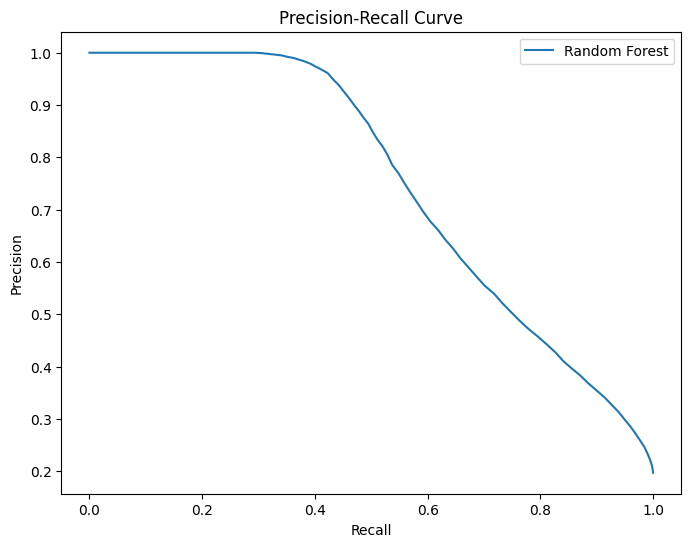

In [38]:
precision, recall, _ = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

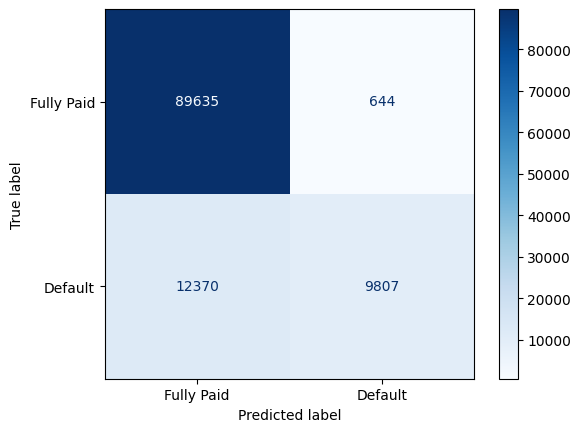

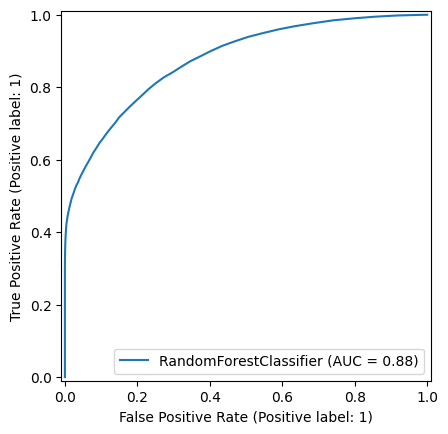

In [44]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_base, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(rf_base, X_test, y_test)

In [87]:
auprc_base = average_precision_score(y_test, y_probs)
print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")


Area Under the Precision-Recall Curve (AUPRC): 0.7456


## Tuning with F1-weighted (any class weight)

In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 400, 600],
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Added class_weight parameter
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1_weighted')

random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': None, 'bootstrap': False}
Best Score: 0.8662064742211784


In [ ]:
y_train_pred_rc = random_search.predict(X_train)
y_pred_base_rc = random_search.predict(X_test)
y_probs_rc = random_search.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_rc, train=True)
print_score(y_test, y_pred_base_rc, train=False)

Train Result:
Accuracy Score: 99.58%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.994798      1.000000  0.995805       0.997399       0.995827
recall          1.000000      0.978786  0.995805       0.989393       0.995805
f1-score        0.997392      0.989280  0.995805       0.993336       0.995788
support    179374.000000  44217.000000  0.995805  223591.000000  223591.000000
_________________
Confusion Matrix: 
 [[179374      0]
 [   938  43279]]

Test Result:
Accuracy Score: 88.49%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.878545      0.948267  0.884933       0.913406       0.892295
recall         0.994096      0.440547  0.884933       0.717321       0.884933
f1-score       0.932755      0.601601  0.884933       0.767178       0.867450
support    90279.000000  22177.000000  0.884933  112456.000000  

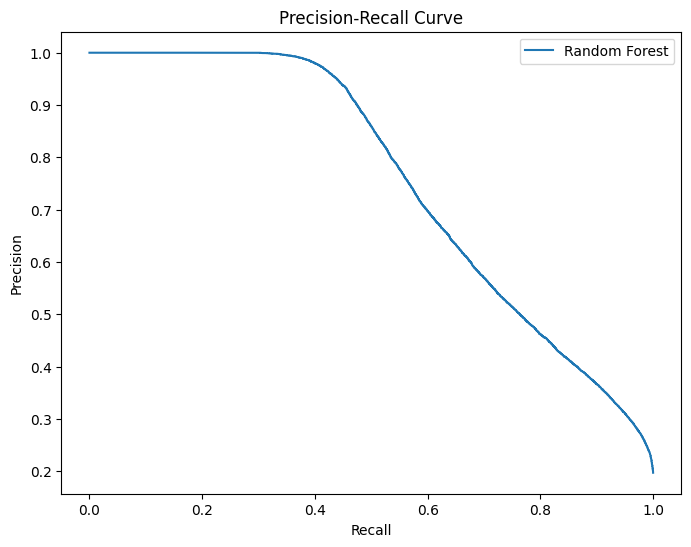

In [74]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rc)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

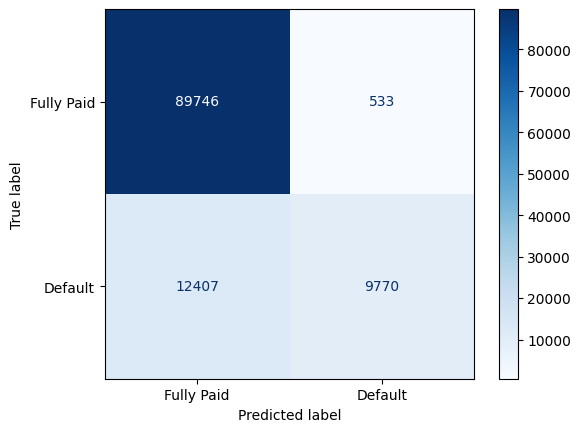

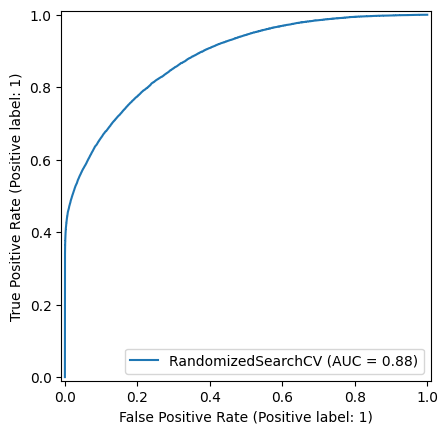

In [75]:
disp = ConfusionMatrixDisplay.from_estimator(
    random_search, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(random_search, X_test, y_test)

In [89]:
auprc_base = average_precision_score(y_test, y_probs_rc)
print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")

Area Under the Precision-Recall Curve (AUPRC): 0.7568


## Tuning with Average Precision Recall

In [97]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 400, 600],
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Added class_weight parameter
}

auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

rf = RandomForestClassifier(random_state=42)

random_search_auc = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring=auprc_scorer)

random_search_auc.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search_auc.best_params_)
print("Best Score:", random_search_auc.best_score_)

Best Parameters: {'n_estimators': 50, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': True}
Best Score: 0.7774536474494619


In [98]:
y_train_pred_rc_auc = random_search_auc.predict(X_train)
y_pred_base_rc_auc = random_search_auc.predict(X_test)
y_probs_rc_auc = random_search_auc.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_rc_auc, train=True)
print_score(y_test, y_pred_base_rc_auc, train=False)

Train Result:
Accuracy Score: 80.97%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.943572      0.512024  0.809702       0.727798       0.858230
recall          0.811310      0.803175  0.809702       0.807243       0.809702
f1-score        0.872457      0.625373  0.809702       0.748915       0.823594
support    179374.000000  44217.000000  0.809702  223591.000000  223591.000000
_________________
Confusion Matrix: 
 [[145528  33846]
 [  8703  35514]]

Test Result:
Accuracy Score: 80.48%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.939103      0.503246  0.804795       0.721175       0.853149
recall         0.809324      0.786355  0.804795       0.797840       0.804795
f1-score       0.869397      0.613725  0.804795       0.741561       0.818977
support    90279.000000  22177.000000  0.804795  112456.000000  

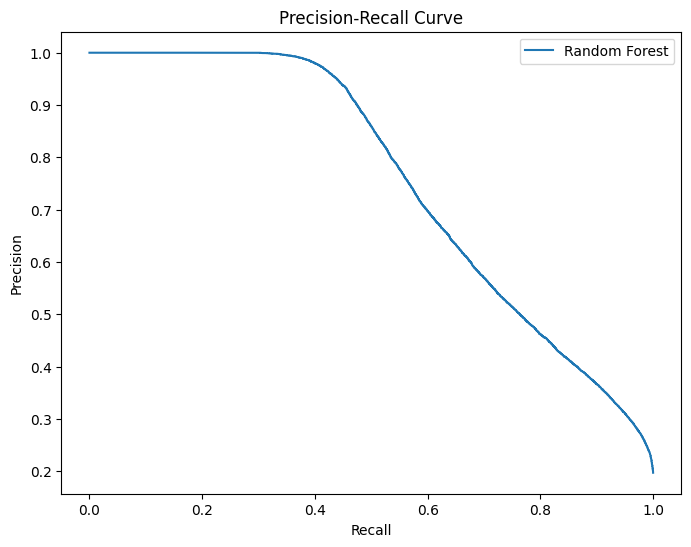

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rc)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

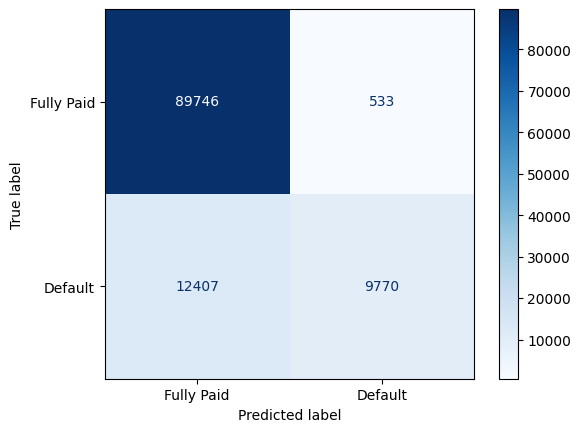

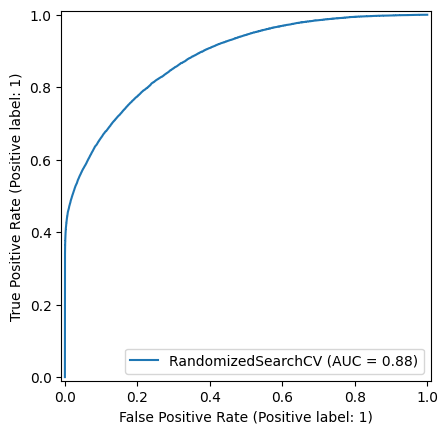

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    random_search, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(random_search, X_test, y_test)

In [ ]:
auprc_base = average_precision_score(y_test, y_probs_rc)
print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")

Area Under the Precision-Recall Curve (AUPRC): 0.7568


## Tuning with F1-weighted

In [77]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 400, 600],
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42, class_weight = "balanced")

random_search_balanced_rc = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1_weighted')

random_search_balanced_rc.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search_balanced_rc.best_params_)
print("Best Score:", random_search_balanced_rc.best_score_)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.5, 'max_depth': None, 'bootstrap': True}
Best Score: 0.8678647014391093


In [78]:
y_train_pred_rc_balanced = random_search_balanced_rc.predict(X_train)
y_pred_base_rc_balanced = random_search_balanced_rc.predict(X_test)
y_probs_rc_balanced = random_search_balanced_rc.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_rc_balanced, train=True)
print_score(y_test, y_pred_base_rc_balanced, train=False)

Train Result:
Accuracy Score: 96.99%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.986578      0.905678  0.969865       0.946128       0.970580
recall          0.975710      0.946152  0.969865       0.960931       0.969865
f1-score        0.981114      0.925473  0.969865       0.953293       0.970110
support    179374.000000  44217.000000  0.969865  223591.000000  223591.000000
_________________
Confusion Matrix: 
 [[175017   4357]
 [  2381  41836]]

Test Result:
Accuracy Score: 86.96%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.908039      0.689801   0.86962       0.798920       0.865001
recall         0.931978      0.615773   0.86962       0.773875       0.869620
f1-score       0.919853      0.650689   0.86962       0.785271       0.866772
support    90279.000000  22177.000000   0.86962  112456.000000  

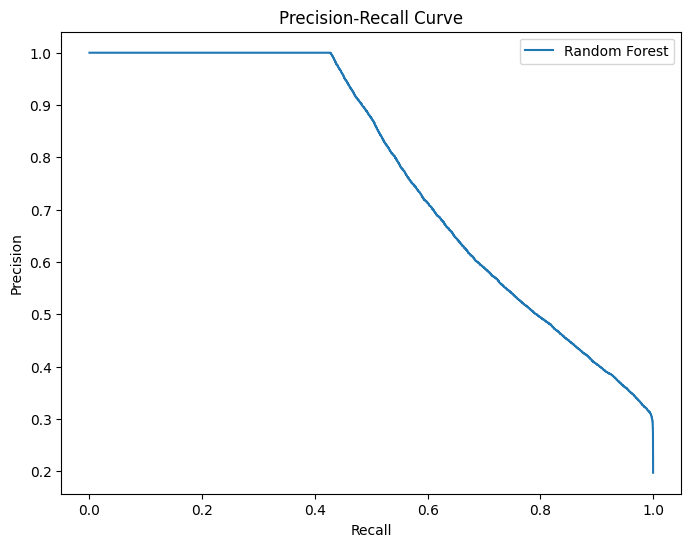

In [79]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rc_balanced)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

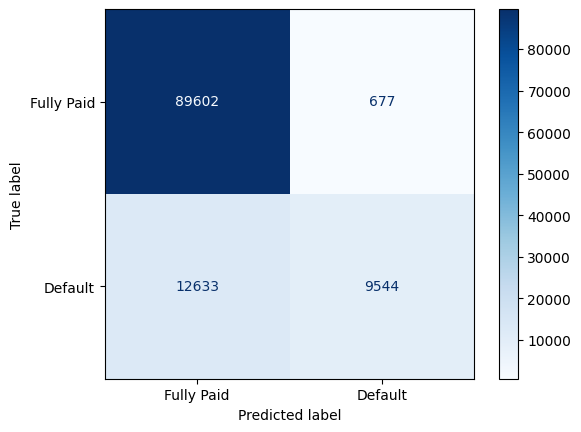

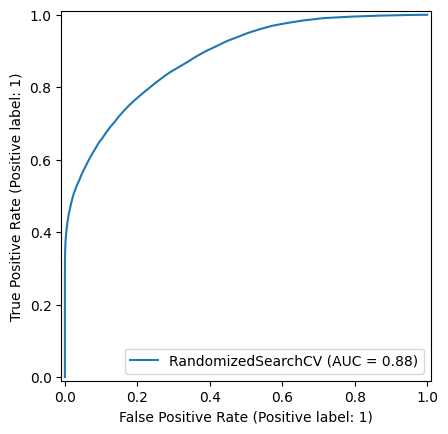

In [49]:
disp = ConfusionMatrixDisplay.from_estimator(
    random_search, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(random_search, X_test, y_test)

In [88]:
auprc_base = average_precision_score(y_test, y_probs_rc_balanced)
print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")

Area Under the Precision-Recall Curve (AUPRC): 0.7737


# Random Forest w/ Undersampling

## Base Model

In [14]:
rus = RandomUnderSampler(random_state=42)

In [15]:
X_under, y_under = rus.fit_resample(X_train, y_train)

In [16]:
print(X_under.shape)
print(y_under.shape)

(88434, 72)
(88434,)


In [17]:
print('Fully Paid:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Charged Off:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Fully Paid: 44217 / 50.0 % of the dataset
Charged Off: 44217 / 50.0 % of the dataset


In [18]:
base_rf = RandomForestClassifier(random_state=42)

In [19]:
pipeline = Pipeline([
    ('undersample', rus),
    ('classifier', base_rf)
])

In [56]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('undersample', RandomUnderSampler(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [57]:
y_train_pred_under = pipeline.predict(X_train)
y_pred_base_under = pipeline.predict(X_test)

y_probs_unnder = pipeline.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_under, train=True)
print_score(y_test, y_pred_base_under, train=False)

Train Result:
Accuracy Score: 87.20%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       1.000000      0.607135  0.872034       0.803567       0.922308
recall          0.840490      1.000000  0.872034       0.920245       0.872034
f1-score        0.913333      0.755549  0.872034       0.834441       0.882130
support    179374.000000  44217.000000  0.872034  223591.000000  223591.000000
_________________
Confusion Matrix: 
 [[150762  28612]
 [     0  44217]]

Test Result:
Accuracy Score: 78.72%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.935270      0.475736  0.787152       0.705503       0.844647
recall         0.789508      0.777562  0.787152       0.783535       0.787152
f1-score       0.856230      0.590305  0.787152       0.723268       0.803788
support    90279.000000  22177.000000  0.787152  112456.000000  

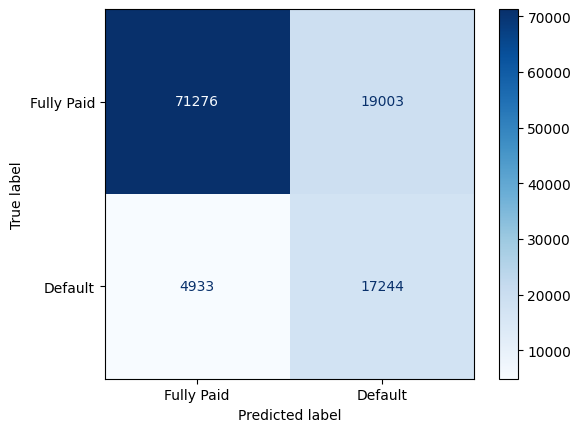

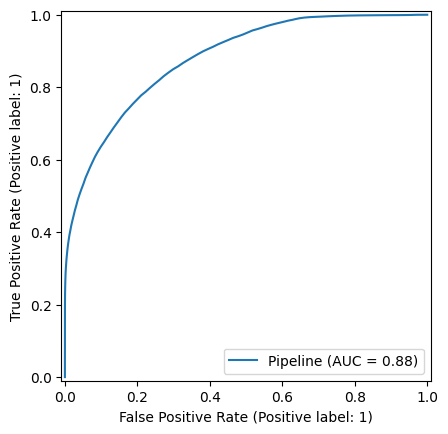

In [58]:
disp = ConfusionMatrixDisplay.from_estimator(
    pipeline, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(pipeline, X_test, y_test)

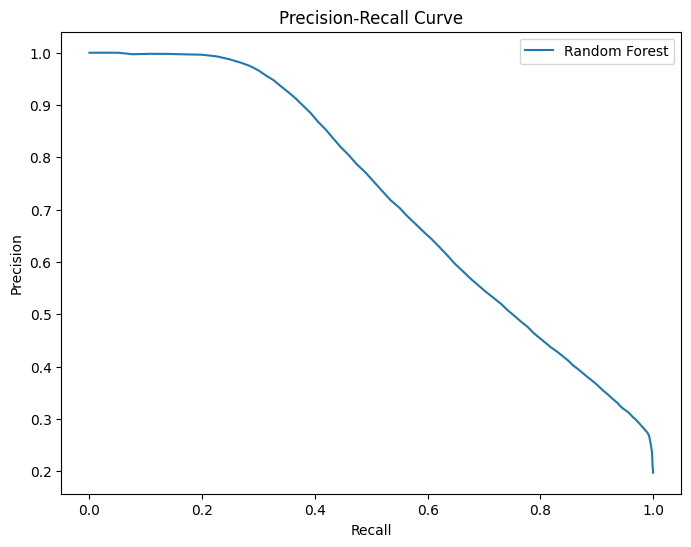

In [59]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_unnder)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [92]:
auprc_base = average_precision_score(y_test, y_probs_unnder)
print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")

Area Under the Precision-Recall Curve (AUPRC): 0.7203


## Tuning with F1 Score

In [66]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200, 400, 600],
    'classifier__max_depth': [None, 5, 10, 15, 20, 30],
    'classifier__min_samples_split': [2, 5, 10, 15, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 6, 8],
    'classifier__max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'classifier__bootstrap': [True, False]
}


random_search_under = RandomizedSearchCV(estimator=pipeline,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1')

random_search_under.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search_under.best_params_)
print("Best Score:", random_search_under.best_score_)

Best Parameters: {'classifier__n_estimators': 50, 'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 0.5, 'classifier__max_depth': 10, 'classifier__bootstrap': False}
Best Score: 0.6169523840849555


In [67]:
y_train_pred_rc_under = random_search_under.predict(X_train)
y_pred_base_rc_under = random_search_under.predict(X_test)
y_probs_rc_under = random_search_under.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_rc_under, train=True)
print_score(y_test, y_pred_base_rc_under, train=False)

Train Result:
Accuracy Score: 80.81%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.943068      0.509339  0.808056       0.726204       0.857295
recall          0.809616      0.801728  0.808056       0.805672       0.808056
f1-score        0.871261      0.622930  0.808056       0.747096       0.822152
support    179374.000000  44217.000000  0.808056  223591.000000  223591.000000
_________________
Confusion Matrix: 
 [[145224  34150]
 [  8767  35450]]

Test Result:
Accuracy Score: 80.34%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.938844      0.500977  0.803399       0.719911       0.852494
recall         0.807718      0.785814  0.803399       0.796766       0.803399
f1-score       0.868359      0.611871  0.803399       0.740115       0.817778
support    90279.000000  22177.000000  0.803399  112456.000000  

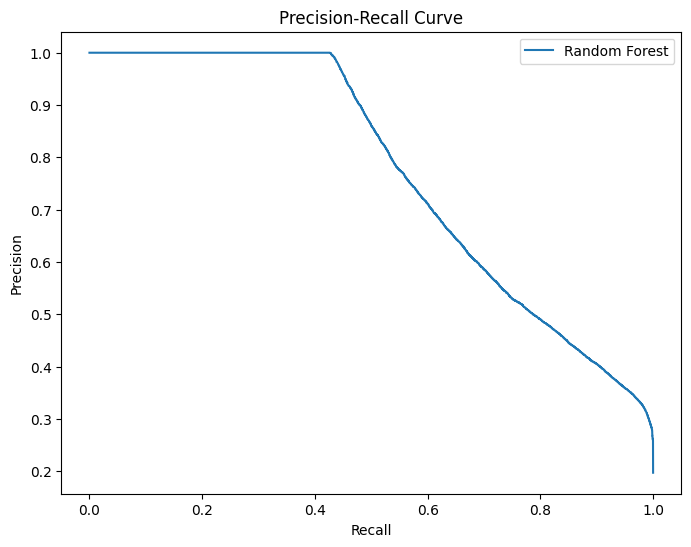

In [68]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rc_under)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

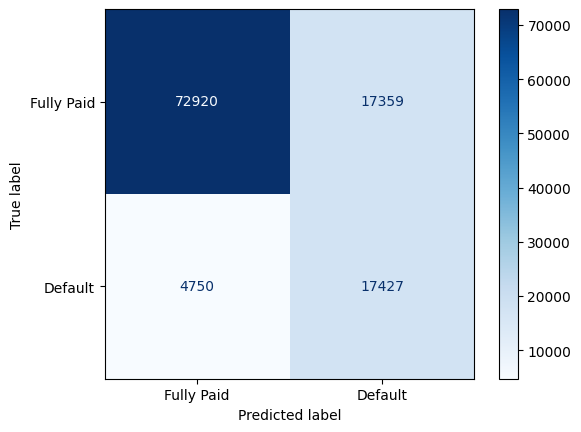

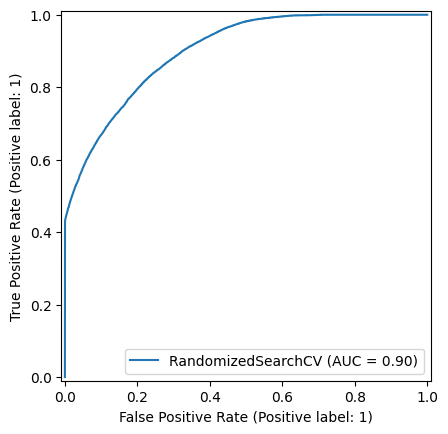

In [69]:
disp = ConfusionMatrixDisplay.from_estimator(
    random_search_under, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(random_search_under, X_test, y_test)

In [93]:
auprc_base = average_precision_score(y_test, y_probs_rc_under)
print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")

Area Under the Precision-Recall Curve (AUPRC): 0.7713


## Tuning with Average Precision Score

In [24]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200, 400, 600],
    'classifier__max_depth': [None, 5, 10, 15, 20, 30],
    'classifier__min_samples_split': [2, 5, 10, 15, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 6, 8],
    'classifier__max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'classifier__bootstrap': [True, False]
}

auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

random_search_under_auc = RandomizedSearchCV(estimator=pipeline,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring=auprc_scorer)

random_search_under_auc.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search_under_auc.best_params_)
print("Best Score:", random_search_under_auc.best_score_)

c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best Parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 6, 'classifier__max_features': 0.7, 'classifier__max_depth': 20, 'classifier__bootstrap': True}
Best Score: 0.7768705684177336


In [25]:
y_train_pred_rc_auc_under = random_search_under_auc.predict(X_train)
y_pred_base_rc_auc_under = random_search_under_auc.predict(X_test)
y_probs_rc_auc_under = random_search_under_auc.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_rc_auc_under, train=True)
print_score(y_test, y_pred_base_rc_auc_under, train=False)

Train Result:
Accuracy Score: 84.58%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.976920      0.567907  0.845785       0.772414       0.896034
recall          0.827316      0.920709  0.845785       0.874013       0.845785
f1-score        0.895916      0.702501  0.845785       0.799208       0.857666
support    179374.000000  44217.000000  0.845785  223591.000000  223591.000000
_________________
Confusion Matrix: 
 [[148399  30975]
 [  3506  40711]]

Test Result:
Accuracy Score: 80.03%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.942899      0.496099  0.800304       0.719499       0.854787
recall         0.799677      0.802859  0.800304       0.801268       0.800304
f1-score       0.865402      0.613257  0.800304       0.739330       0.815678
support    90279.000000  22177.000000  0.800304  112456.000000  

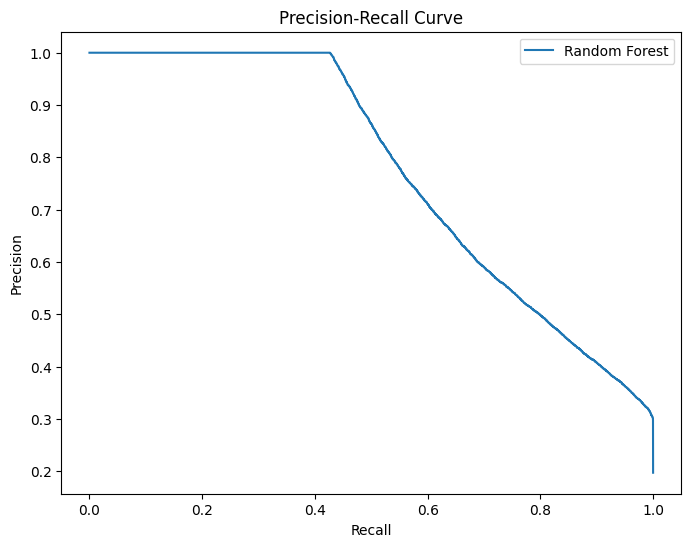

In [26]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rc_auc_under)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

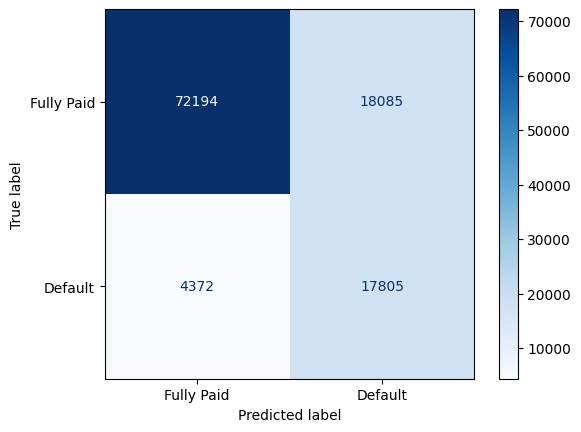

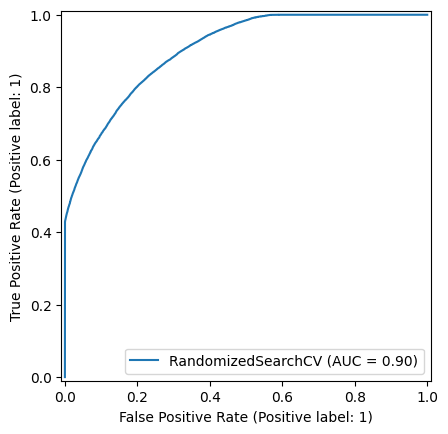

In [27]:
disp = ConfusionMatrixDisplay.from_estimator(
    random_search_under_auc, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(random_search_under_auc, X_test, y_test)

In [29]:
auprc_base = average_precision_score(y_test, y_probs_rc_auc_under)
print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")

Area Under the Precision-Recall Curve (AUPRC): 0.7735
